---
title: "Report"
format:
  html:
    code-fold: true # or true to initially hide the code
    code-tools: true
    code-line-numbers: true
    highlight-style: github
    code-summary: "Show the code"
    execute:
      echo: true
      warning: false
      error: false
  pdf:
    execute:
      echo: false
      warning: false
      error: false
subtitle: "Group A: Alexander Benz, Lukas Zaiser, Sven Weiß"
---

In [22]:
# Basics
import numpy as np
import pandas as pd

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, f_regression

# Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso, LassoCV, LinearRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy import stats
import xgboost as xg

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Others
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle

# Visualization
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()
%matplotlib inline

## Introduction and data

In the last 30 years, the dating approach has changed and has become increasingly difficult. The willingness to date has decreased, dating is too expensive and time consuming, we have too many (perceived) options to date someone and we struggle because of accepting too easily negative sex stereotypes. In the 19th century, a custom in the United States called New Year’s Calling, was that on New Year's Day many young, single women would hold an Open House (a party or reception during which a person's home is open to visitors) on 1 January where they would invite eligible bachelors, both friends and strangers, to stop by for a brief (no more than 10–15-minute) visit. This custom was established with the term SpeedDating as a registered trademark by Aish HaTorah, who began hosting SpeedDating events in 1998. 

10 years later, Fisman et al. conducted a survey regarding speed dating habits and collected 8,000 observations during his 2 – year observation in his paper Gender Differences in Mate Selection: Evidence from a Speed Dating Experiment. Because speed dating has become more and more interesting in the last few years and also through Corona a completely new dating approach has emerged, we wanted to analyse this dataset with the following questions in mind:

- **What are the most effective personal characteristics to achieve a match in opposite sex speed dating?**
  - A match may be a high like value (1 - 10, regression) or a positive match (1 or 0, classification)

The following hypotheses support our research question:

Null hypothesis: 

-   **There is no affection of having specific characteristics regarding match selection of the survey participants**
-   **There is no correlation between shared interests, attributes and getting a match**

Hypotheses:

-   **Survey participants who both have the specific characteristics same race and opposite gender tend to achieve more matches**
-   **Survey participants with a higher income tend to achieve more matches than survey participants with a lower income**
-   **Achieving matches because of having the same specific characteristics occur in both sexes**
-   **Three weeks after the event, males called women more often**

Our dataset was pretty helpful in answering this and more questions, as there were a lot of helpful features:

We want to answer our research questions in 4 steps:

- Step 1 Importing the required libraries
- Step 2 Cleaning the dataset
- Step 3 Analyzing the dataset
- Step 4 Preparing the model
- Step 5 Analyzing the model

The main, effective variables we want to look at to answer our research questions are 'Match' (as our predictor variable for the classification) including the personal attributes/features and 'Like' for the regression.
For all variables, we use descriptive terms in order to recognize them better.
First, we want to analyze the importance of each personal attributes for achieving a match (classification) on the one hand and for the strength of a like (regression) on the other hand.

In [3]:
folder = '../models/' 
regmodelname = 'clf_xgboost_20221222.pkl'
classmodelname = 'clf_match_20221222.pkl'
 
# TODO: install xgboost
#with open(folder + regmodelname, 'rb') as file:
#    regmodel = pickle.load(file)
#with open(folder + classmodelname, 'rb') as file:
#    classmodel = pickle.load(file)

df = pd.read_csv("../data/interim/TransformedData", delimiter=",", index_col=0)

cat_vars = [
    "gender",
    "match",
    "samerace",
    "race_o",
    "race",
]

float_vars = [
    "int_corr"
]

int_vars = [   
    "age",
    "age_o",
    "imprace",
    "attr",
    "sinc",
    "intel",
    "fun",
    "amb",
    "shar",
    "like",
    "prob",
    "order",
    "you_call",
    "them_cal"
]

df[cat_vars]=df[cat_vars].astype("category",copy=False)
df[float_vars]=df[float_vars].astype("float",copy=False)

df['calls'] = df['you_call'] + df['them_cal']

df = df.rename(columns=
{
    "match": "Match",
    "fun": "Humor",
    "shar": "Shared_interests",
    "attr": "Attractivity",
    "prob": "Probability",
    "intel": "Intelligence",
    "sinc": "Sincerety",
    "amb": "Ambition",
    "gender": "Gender",
    "samerace": "Same_race",
    "race": "Race",
    "race_o": "Race_opposite",
    "calls": "Calls",
    "age": "Age",
    "age_o": "Age_opposite",
    "imprace": "Importance_same_race",
    "order": "Order",
    "like": "Like",
    "int_corr": "Interests_correlation",
})

variables_c = [
    'Match',
    'Humor',
    'Shared_interests',
    'Attractivity',
    'Probability',
    'Intelligence',
    'Sincerety',
    'Ambition',
    'Gender',
    'Same_race',
    'Race',
    'Race_opposite',
    'Calls',
    'Age',
    'Age_opposite',
    'Importance_same_race',
    'Order',
    'Interests_correlation'
]

### Data cleaning

For the calls variable, we assume that NaN had zero calls. This is of cause only an estimation. This value was collected after the events so not many answered this question.
For all the other attributes we drop the NaN values because the ratio is rather small.

In [4]:
cat_features = ['Gender', 'Same_race', 'Race', 'Race_opposite']
personal_features = ['Humor', 'Shared_interests', 'Attractivity', 'Intelligence', 'Sincerety', 'Ambition']
num_features = ['Probability', 'Calls', 'Age', 'Age_opposite', 'Order', 'Interests_correlation', 'Importance_same_race']
features_classification = cat_features + personal_features + num_features

features_regression = personal_features + [ 'Probability', 'Like' ]

y_label_r = 'Like'
X_r = df[features_regression]
y_r = df[y_label_r]

y_label_c = 'Match'

In [5]:
def plot_missing(df):
    '''
    This function shows distribution of missing values for all variables of the dataset in the form of a graph.
    '''
    plt.figure(figsize=(10, 4),dpi=80)
    sns.heatmap(df.isnull().transpose(), xticklabels=False, cbar=False, cmap='viridis')
    plt.title('Distribution of Missing Values among Variables', fontsize=20)
    plt.show()

Overall, there are a lot of missing values for questions that were asked after the events like the *_2 and *_3 attributes, so we concentrated on the answers given at the events.

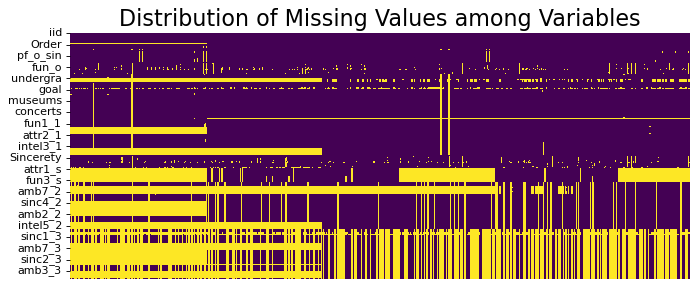

In [6]:
plot_missing(df)

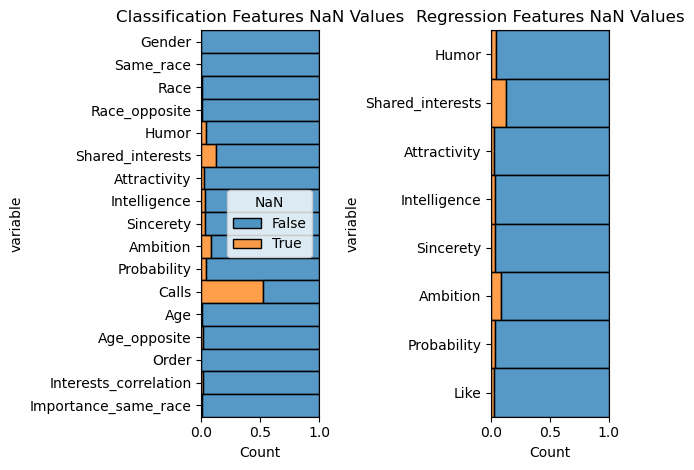

In [7]:
fig, ax2=plt.subplots(ncols=2)
g = sns.histplot(
    data=df[features_classification].isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill",ax=ax2[0]
)

g2 = sns.histplot(
    data=df[features_regression].isna().melt(value_name="NaN"),
    y="variable",
    hue="NaN",
    multiple="fill",ax=ax2[1]
)


ax2[0].set_title("Classification Features NaN Values")
ax2[1].set_title("Regression Features NaN Values")

plt.legend([],[], frameon=False)

fig.tight_layout()

In [13]:
df_r= df[features_regression].copy()
df_r.dropna(inplace=True)
df_r.reset_index(inplace=True, drop=True)

df_c = df[variables_c] 
df_c = df_c.fillna({ 'Calls': 0 })
df_c = df_c.dropna()
df_c.reset_index(inplace=True, drop=True)

X_c = df_c[features_classification]
y_c = df_c[y_label_c]

print('\n--- Regression ---')
print(X_r.info(verbose=True))
print('\n--- Classification ---')
print(X_c.info(verbose=True))


--- Regression ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8378 entries, 0 to 8377
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Humor             8028 non-null   float64
 1   Shared_interests  7311 non-null   float64
 2   Attractivity      8176 non-null   float64
 3   Intelligence      8082 non-null   float64
 4   Sincerety         8101 non-null   float64
 5   Ambition          7666 non-null   float64
 6   Probability       8069 non-null   float64
 7   Like              8138 non-null   float64
dtypes: float64(8)
memory usage: 847.1 KB
None

--- Classification ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784 entries, 0 to 6783
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Gender                 6784 non-null   category
 1   Same_race              6784 non-null   category
 2   Race     

## Methodology

After cleaning our dataset and our initial exploratory data analysis, we can see the relationships between the respective outcome and possible predictors for each of the classification and regression.

For **regression** we use the following models:

- Linear Regression,
- Multiple Regression 
- Lasso Regression
- XGBOOST Regression Models

The considered metrics for regression are:

- R2-Score
- Mean squared error
- Mean Absolute Error
- Root Mean Squared Error

For **classification** we use the following models:

- Logistic Regression

The considered metrics for logicstic regression are:

- Confusion Matrix
- Precision, Recall, Accuracy and F1 scores
- Precision-Recall curve
- ROC curve and AUC value

**Model selection process for Classification:**
Besides logistic regression there are other types of classification algorithms like Naïve Bayes, Stochastic Gradient Descent, K-Nearest Neighbours, Decision Tree, Random Forest and Support Vector Machine. Since we need a machine learning algorithm which is most useful for understanding the influence of several independent variables on our single outcome variable, we use the Logistic Regression, which is modelling the probabilities describing the possible outcomes of a single trial.

For the Logistic Regression, we use the LogisticRegressionCV model. On default, this model includes a 5 cross fold validation with Stratified K-Folds so there is no need to do further training and validation.<br>
See the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)


**Model selection process for Regression:**
For the Regression analysis we need a type of predictive modelling which investigates the relationship between a dependent (target) and independent variable(s) (predictor). This technique is used for forecasting, time series modelling and finding the cause-effect relationship between the variables.

Evaluating the model accuracy is an essential part of the process in evaluating the performance of machine learning models to describe how well the model is performing in its predictions. The basic concept of accuracy evaluation is to compare the original target with the predicted one according to certain metrics. We use different models and interpret their values. We start by using linear regression in order to model the relationship between the features and the target variable. Second, we use Lasso regression as a type of linear regression that uses shrinkage. Shrinkage is where data values are shrunk towards a central point, like the mean. Like Ridge regression, Lasso is well-suited for models showing high levels of multicollinearity or when you want to automate certain parts of model selection, like variable selection/parameter elimination. XGBoost  (Extreme Gradient Boosting) is used as an optimized distributed gradient boosting library and for supervised Machine Learning problems.

## Regression

To get the most important features, we do a SelectKBest Selection with a F_Regression scoring function with all numerical values to get the top 20 highest scoring variables for regression analysis

The F-Regression is an univariate linear regression test returning F-statistic and p-values.

It is a quick linear model for testing the effect of a single regressor, sequentially for many regressors.
This is done in 2 steps:

The cross correlation between each regressor and the target is computed using r_regression as:
$$E[(X[:, i] - mean(X[:, i])) * (y - mean(y))] / (std(X[:, i]) * std(y))$$

It is converted to an F-score and then to a p-value.
f_regression is derived from r_regression and will rank features in the same order if all the features are positively correlated with the target.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression.

When looking at the barchart, it can be determined that **Attractivity, Humor, Sincerety, Intelligence, Shared Interests, Probability** and **Ambition** are by far the most impactful features

In [9]:
dfregressionvars = pd.read_csv("../data/interim/TransformedData", delimiter=",", index_col=0)
float_vars = [
    "int_corr",
    "pf_o_att",
    "pf_o_sin",
    "pf_o_int",
    "pf_o_fun",
    "pf_o_amb",
    "pf_o_sha",
    "income",
    "attr1_1",
    "sinc1_1",
    "intel1_1",
    "fun1_1",
    "amb1_1",
    "shar1_1",
    "attr4_1",
    "sinc4_1",
    "intel4_1",
    "fun4_1",
    "amb4_1",
    "shar4_1",
    "attr2_1",
    "sinc2_1",
    "intel2_1",
    "fun2_1",
    "amb2_1",
    "shar2_1"
]

int_vars = [
    "gender",    
    "samerace",
     "met", 
     "age_o",
    "race_o",
    "dec_o",
    "met_o",
    "attr_o",
    "sinc_o",
    "intel_o",
    "fun_o",
    "amb_o",
    "shar_o",
    "like_o",
    "prob_o",
    "age",
    "imprace",
    "imprelig",
    "sports",
    "tvsports",
    "exercise",
    "dining",
    "museums",
    "art",
    "hiking",
    "gaming",
    "clubbing",
    "reading",
    "tv",
    "theater",
    "movies",
    "concerts",
    "music",
    "shopping",
    "yoga",
    "exphappy",
    "attr3_1",
    "sinc3_1",
    "intel3_1",
    "fun3_1",
    "amb3_1",
    "attr5_1",
    "sinc5_1",
    "intel5_1",
    "fun5_1",
    "amb5_1",
    "attr",
    "sinc",
    "intel",
    "fun",
    "amb",
    "shar",
    "like",
    "prob",
    "attr1_s",
    "sinc1_s",
    "intel1_s",
    "fun1_s",
    "amb1_s",
    "shar1_s",
    "attr3_s",
    "sinc3_s",
    "intel3_s",
    "fun3_s",
    "amb3_s",
    "satis_2",
    "iid",
    "id",
    "idg",
    "wave",
    "round",
    "order",
    "partner",
    "pid",
    "expnum",
    "you_call",
    "them_cal",
    "numdat_3",
    "num_in_3",
    "position",
    "positin1",
]

[Text(0.5, 1.0, 'F_Scores per Feature')]

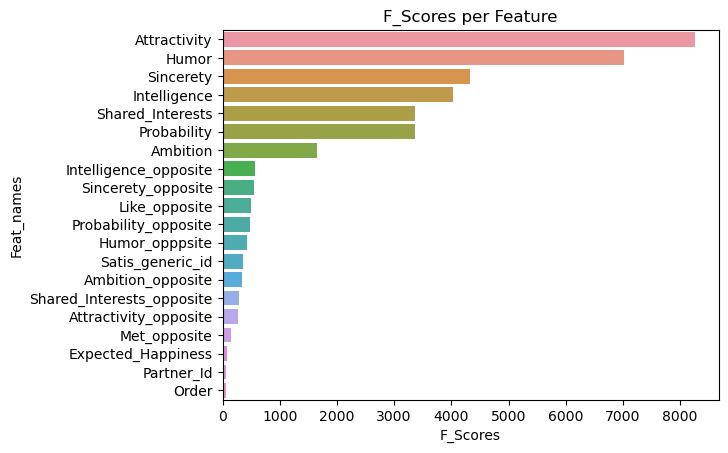

In [11]:
df2=dfregressionvars[float_vars+int_vars].fillna(0).copy()
df2 = df2.rename(columns={"order": "Order", "intel_o": "Intelligence_opposite", "sinc_o": "Sincerety_opposite", "like_o": "Like_opposite", "prob_o": "Probability_opposite", "fun_o": "Humor_opppsite", "satis_2": "Satis_generic_id", "amb_o": "Ambition_opposite", "shar_o": "Shared_Interests_opposite", "attr_o": "Attractivity_opposite", "met_o": "Met_opposite", "exphappy": "Expected_Happiness", "pid": "Partner_Id", "fun": "Humor", "shar": "Shared_Interests", "attr": "Attractivity", "prob": "Probability", "intel": "Intelligence", "sinc": "Sincerety", "amb": "Ambition", "age": "Age", "like": "Like"})

dflike=df2["Like"]
df2.drop(columns="Like",inplace=True)

#Suppose, we select 5 features with top 20 Fisher scores
selector = SelectKBest(f_regression,k=20 )
X_new = selector.fit(df2, dflike)
names = df2.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])

#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
a=sns.barplot(ns_df_sorted,y="Feat_names",x="F_Scores")
a.set(title='F_Scores per Feature')

To make sure that we do not have any multicolinnearity, between the used variables we checked for it.

As seen in the graph below, where is almost no colinearity besides **Intelligence** with **Sincerity and Ambition** or  **Humor** with **Shared Interests and Attractivity**

[Text(0.5, 1.0, 'Multicolinearity Check')]

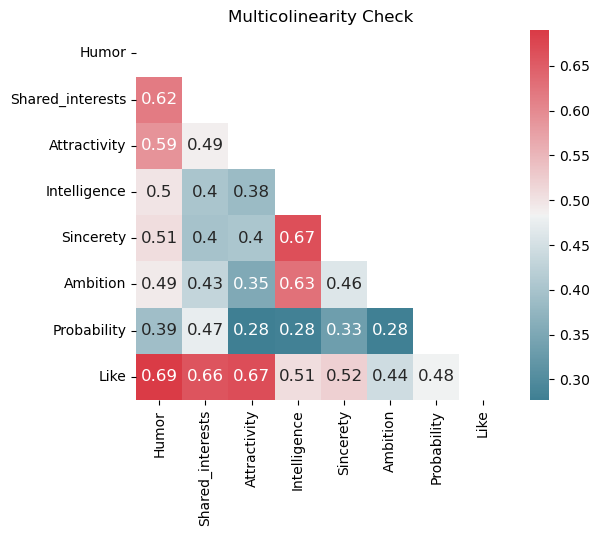

In [14]:
# Inspect correlation
# Calculate correlation using the default method ( "pearson")
corr = df_r.corr()
# optimize aesthetics: generate mask for removing duplicate / unnecessary info
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Generate a custom diverging colormap as indicator for correlations:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12}).set(title="Multicolinearity Check")

Furthermore, all variables have a linear relationship, so Splines or Polinominal Regression models are not required.

In [16]:
alt.Chart(df_r).mark_bar().encode(
    alt.X(alt.repeat("column"), type="quantitative", bin=True),
    y='count()',
).properties(
    width=150,
    height=150
).repeat(
    column=features_regression
).properties(title="Count of record per Feature")

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.RepeatChart(...)

In [17]:
alt.Chart(df_r).mark_circle().encode(
    alt.X(alt.repeat("column"), type="quantitative"),
    y='Like',
).properties(
    width=150,
    height=150
).repeat(
    column=features_regression
).properties(title="Regression Features")

alt.RepeatChart(...)

In [18]:
y_label = features_regression.pop()
features = features_regression

X_r = df_r[features_regression]
y_r = df_r[y_label]
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)
                                                    

### Model selection

With the most important Features selected, Linear Regression, Lasso Regression and XGBoost Linear Regression were chosen as models to train on the dataset.

The following hyperparameters were determined by a Grid Search for Lasso Alpha: **0.018149939617142067**

The following hyperparameters were determined by a Grid Search for XGBoost **(learning_rate= 0.08, n_estimators= 700,booster='gblinear')**

In [23]:
reg = LinearRegression()
reg.fit(X_r_train, y_r_train)

lasso = LassoCV(cv=5,random_state=0,max_iter=15000)
lasso.fit(X_r_train,y_r_train)

# Set best alpha
lasso_best = Lasso(alpha=lasso.alpha_)
lasso_best.fit(X_r_train, y_r_train)

regxg=xg.XGBRegressor(learning_rate= 0.08, n_estimators= 700,booster='gblinear')
regxg.fit(X_r_train, y_r_train)
regxgnolin=xg.XGBRegressor(learning_rate= 0.015, max_depth= 2, n_estimators= 700)
regxgnolin.fit(X_r_train, y_r_train)

y_r__reg_pred=reg.predict(X_r_test)
y_r__lasso_pred=lasso_best.predict(X_r_test)
y_r__xgboost_pred=regxg.predict(X_r_test)

The following formulas are used to determine the MAE, RMSE, Mse and R2 Score:

$$Mean\ squared\ error \ (MSE) = \frac{1}{n} \times \sum_{i=1}^{n}(y_i-\hat{y_i})^2$$
$$Root\ mean\ squared\ error \ (RMSE) = \sqrt{\frac{1}{n} \times \sum_{i=1}^{n}(y_i-\hat{y_i})^2}$$
$$Mean\ absolute\ error \ (MAE) = \frac{1}{n} \times \sum_{i=1}^{n}(y_i-\hat{y_i})$$
$$R \ Squared\ (R2)= 1-(\frac{SSR}{SST}) $$

After fitting and performance testing all models, no real difference can be found.

[Text(0.5, 1.0, 'Model comparison')]

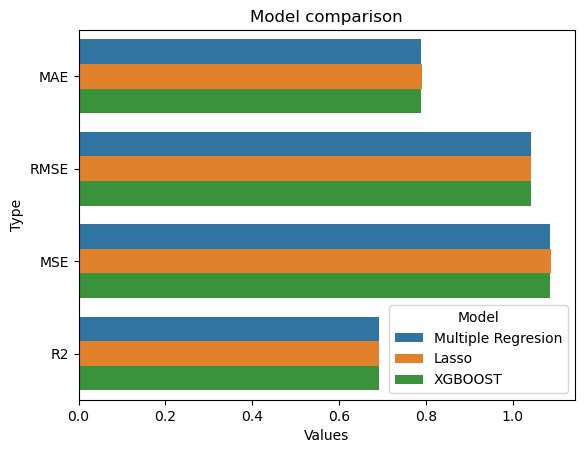

In [25]:
Compdf = pd.DataFrame(
    {
        "Type": ["MAE", "RMSE", "MSE", "R2", "MAE", "RMSE", "MSE", "R2", "MAE", "RMSE", "MSE", "R2"],
        "Values": [
            mean_absolute_error(y_r_test, y_r__reg_pred).round(3),
            mean_squared_error(y_r_test, y_r__reg_pred, squared=False).round(3),
            mean_squared_error(y_r_test, y_r__reg_pred).round(3),
            r2_score(y_r_test, y_r__reg_pred).round(3),
            mean_absolute_error(y_r_test, y_r__lasso_pred).round(3),
            mean_squared_error(y_r_test, y_r__lasso_pred, squared=False).round(3),
            mean_squared_error(y_r_test, y_r__lasso_pred).round(3),
            r2_score(y_r_test, y_r__lasso_pred).round(3),
            mean_absolute_error(y_r_test, y_r__xgboost_pred).round(3),
            mean_squared_error(y_r_test, y_r__xgboost_pred, squared=False).round(3),
            mean_squared_error(y_r_test, y_r__xgboost_pred).round(3),
            r2_score(y_r_test, y_r__xgboost_pred).round(3)],
        "Model":[
            "Multiple Regresion","Multiple Regresion","Multiple Regresion","Multiple Regresion",
            "Lasso","Lasso","Lasso","Lasso",
            "XGBOOST","XGBOOST","XGBOOST","XGBOOST"
            ]})

sns.barplot(Compdf,y="Type",x="Values",hue="Model").set(title='Model comparison')

As for the residuals, it can be stated, that all models also perform roughtly the same with all models overtuning the "10/10" **like** value

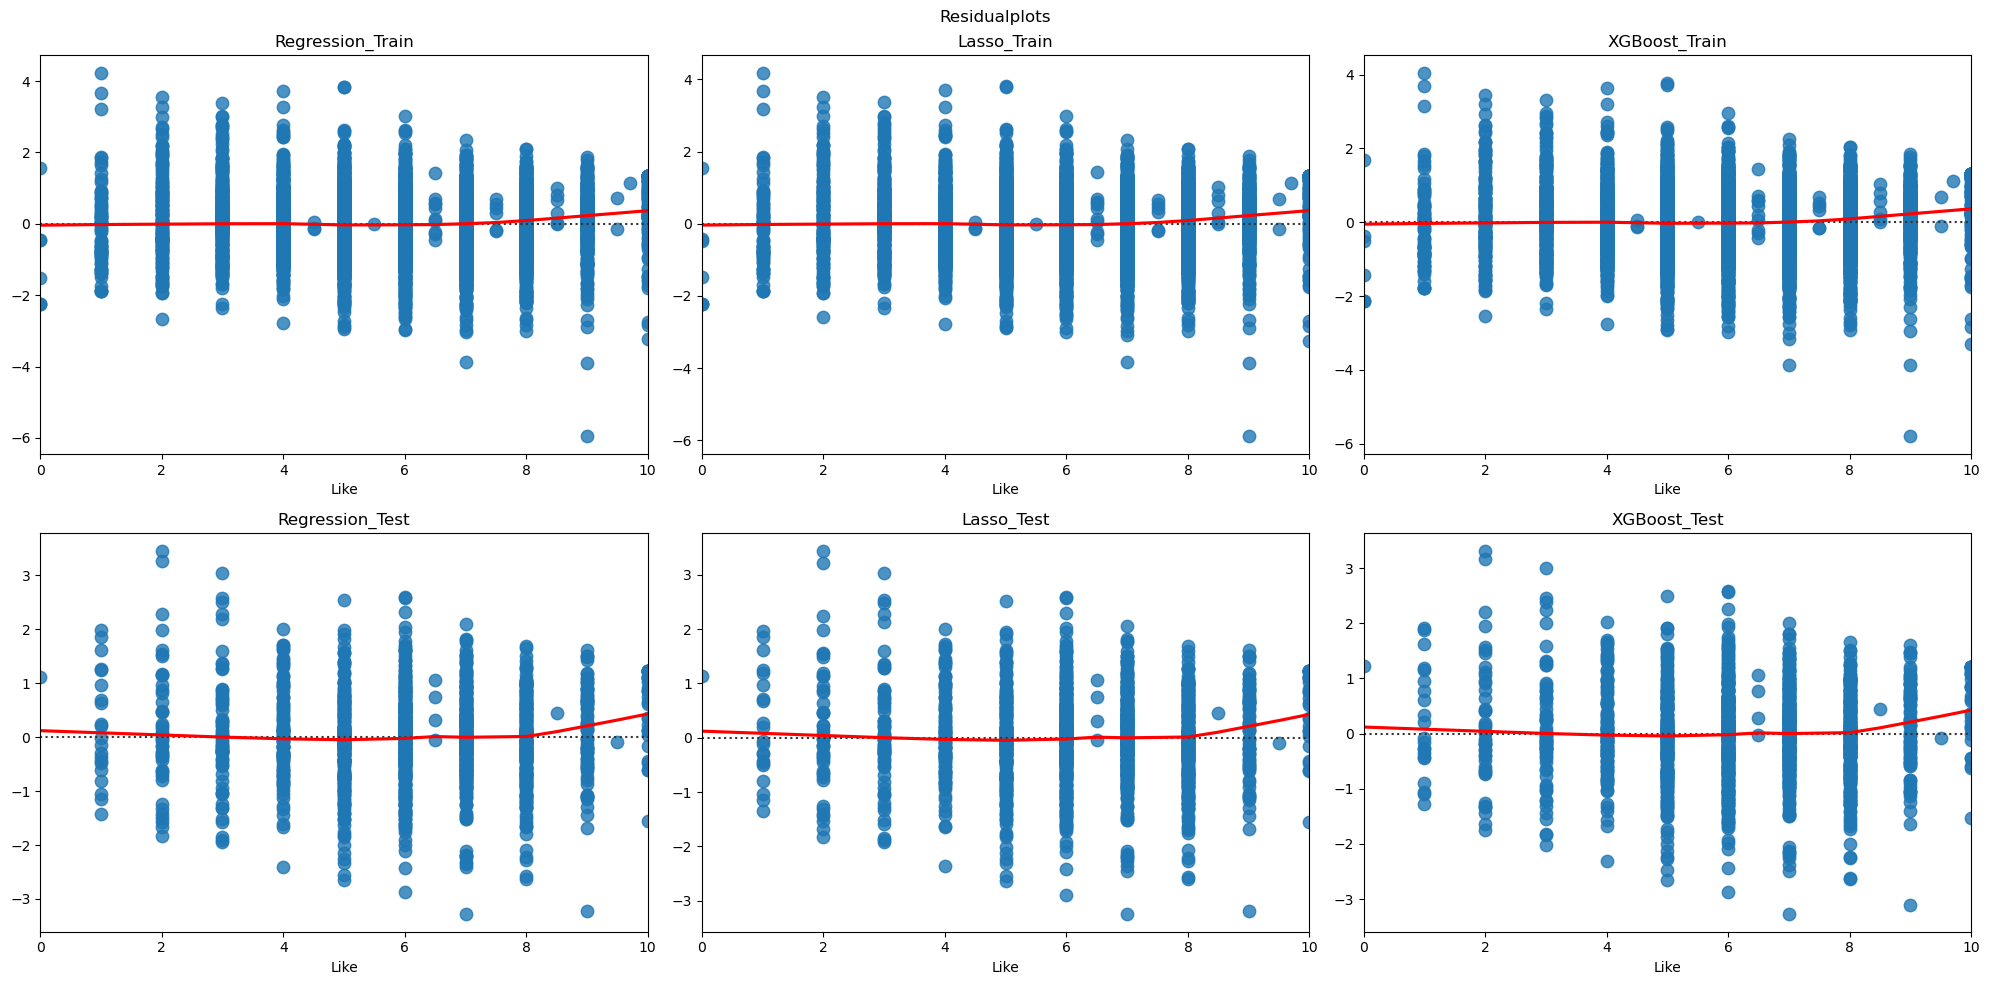

In [26]:
y_predtestreg= reg.predict(X_r_train)
y_predtestlasso=lasso.predict(X_r_train)
y_predtestXG = regxg.predict(X_r_train)
y_predtestXGnoLin= regxgnolin.predict(X_r_train)

fig, ax=plt.subplots(2,3)
sns.residplot(x=y_r_train, y=y_predtestreg, scatter_kws={"s": 80},ax=ax[0,0],lowess=True,line_kws=dict(color="r"))
sns.residplot(x=y_r_train, y=y_predtestlasso, scatter_kws={"s": 80},ax=ax[0,1],lowess=True,line_kws=dict(color="r"))
sns.residplot(x=y_r_train, y=y_predtestXG, scatter_kws={"s": 80},ax=ax[0,2],lowess=True,line_kws=dict(color="r"))
sns.residplot(x=y_r_test, y=y_r__reg_pred, scatter_kws={"s": 80},ax=ax[1,0],lowess=True,line_kws=dict(color="r"))
sns.residplot(x=y_r_test, y=y_r__lasso_pred, scatter_kws={"s": 80},ax=ax[1,1],lowess=True,line_kws=dict(color="r"))
sns.residplot(x=y_r_test, y=y_r__xgboost_pred, scatter_kws={"s": 80},ax=ax[1,2],lowess=True,line_kws=dict(color="r"))

fig.suptitle("Residualplots")
ax[0,0].set_title("Regression_Train")
ax[0,1].set_title("Lasso_Train")
ax[0,2].set_title("XGBoost_Train")
ax[1,0].set_title("Regression_Test")
ax[1,1].set_title("Lasso_Test")
ax[1,2].set_title("XGBoost_Test")

fig.set_size_inches(20,10)
fig.tight_layout()

### Result

After determining that the all the Models have equal performance, the attribute that impacts the like variable most is **attractiveness** 

<AxesSubplot: xlabel='Coefficient', ylabel='Name'>

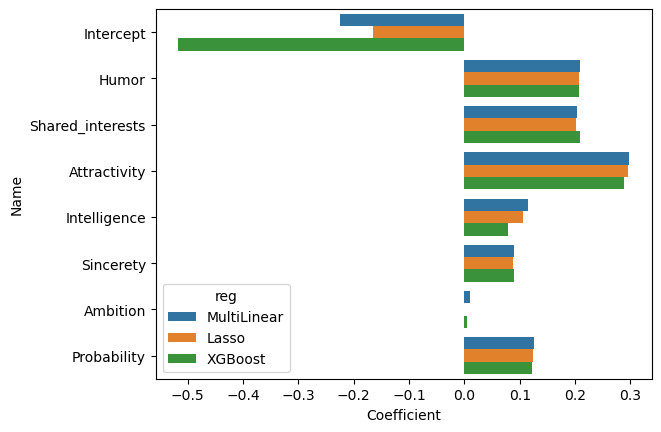

In [27]:
importance = np.abs(reg.coef_)
interceptImp = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient": reg.intercept_, "reg": "MultiLinear"}
)
df_imp = pd.DataFrame({"Coefficient": importance,
                       "Name": features_regression, "reg": "MultiLinear"})

df_imp = pd.concat([interceptImp, df_imp])

importance = np.abs(lasso_best.coef_)
interceptLasso = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient": [lasso_best.intercept_], "reg": "Lasso"}
)
df_lasso = pd.DataFrame({"Coefficient": importance,
                         "Name": features_regression, "reg": "Lasso"})
df_lasso = pd.concat([interceptLasso, df_lasso])
dfdisplay = pd.concat([df_imp, df_lasso])
importance = np.abs(regxg.coef_)
interceptXG = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient": regxg.intercept_, "reg": "XGBoost"}
)
df_xgboost = pd.DataFrame({"Coefficient": importance,
                           "Name": features_regression, "reg": "XGBoost"})
df_xgboost = pd.concat([interceptXG, df_xgboost])
dfdisplay = pd.concat([df_imp, df_lasso, df_xgboost
                       ])
sns.barplot(dfdisplay, y="Name", x="Coefficient", hue="reg")

## Classification

### Exploratory data analysis

The first impression of the data is that all attributes are important.<br>
It's the best to be rated around 7 - 8 to get a match.

We can also see that the data is very unbalanced, where only 1/5 of the dataset is marked as match while the other 4/5 is no match. This may influence the model. 

We do a train/test split with 80/20% of the data.

In [62]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

In [63]:
df_train_c = pd.DataFrame(X_train_c).copy()
df_train_c[y_label_c] = pd.DataFrame(y_train_c)

c1 = alt.Chart(df_train_c).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(y_label_c),
    alt.Size('count()'),
    alt.Color(y_label_c),
    tooltip=['count()']
).properties(
    width=250,
    height=150
).repeat(
    column=personal_features
).interactive().properties(title="Attribute importance to get a match")

c2 = alt.Chart(df_train_c).mark_bar().encode(
    alt.X(y_label_c),
    alt.Y('count()'),
    alt.Color(y_label_c),
    tooltip = ['count()']
).properties(
    width=250,
    height=150
).interactive().properties(title="Match and no-match comparison")

c1 & c2

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

When we are looking at those charts we search for differences between the match and no match results.

For **humor**, **shared interests**, **attractivity** and **probability** we can see again that the charts for **match** start to raise at around five, with a peak at 7-8. The importance for **same race** falls stronger for a match than for no match.

For the other attributes, the charts look pretty similar just with lower amplitudes.

We can conclude that the mentioned attributes are probably important for the model in contrast to the others.

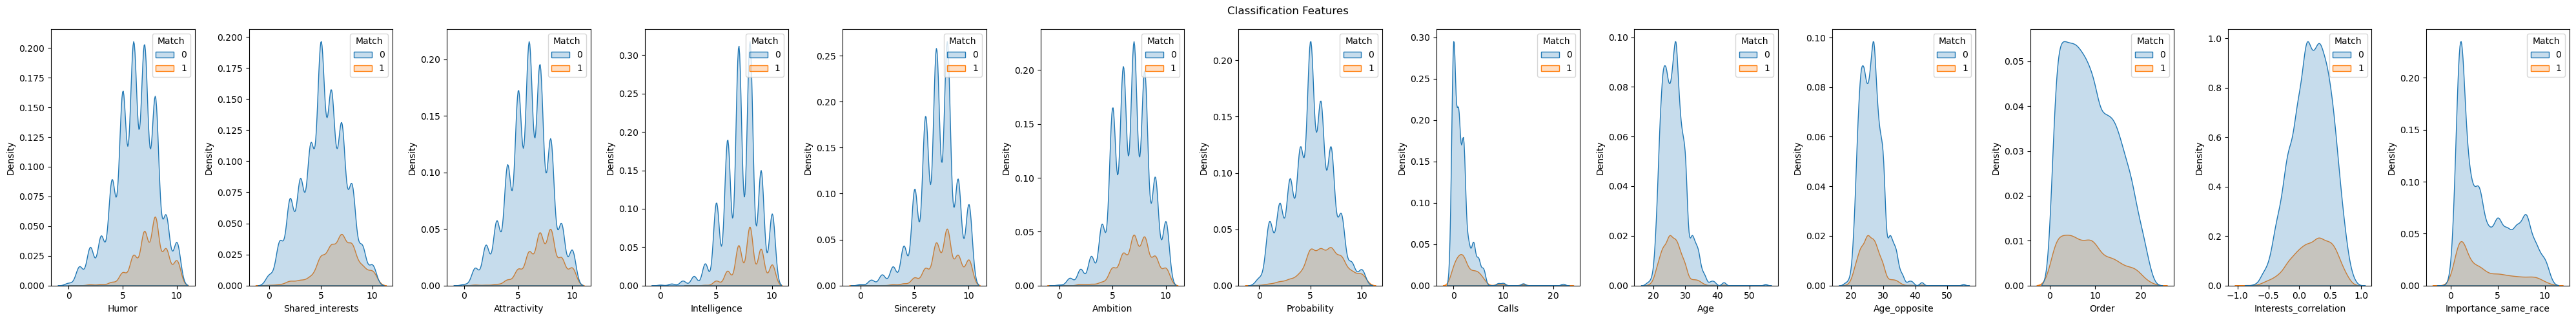

In [64]:
features=personal_features+num_features
fig, ax=plt.subplots(ncols=len(features))
for count, value in enumerate(features):
    sns.kdeplot(data=df,x=value,hue="Match",ax=ax[count],fill=True)
fig.set_size_inches(40,5)
fig.suptitle("Classification Features")
fig.tight_layout()

### Model selection

The most important coefficients for a positive correlation for our model is **Attractivity**, followed by **Humor**, **Interests_correlation** and **Probability**.<br>
We also have strong negative correlations with **Gender** and **Ambition**. 

[Text(0.5, 1.0, 'Coefficient per Attribute')]

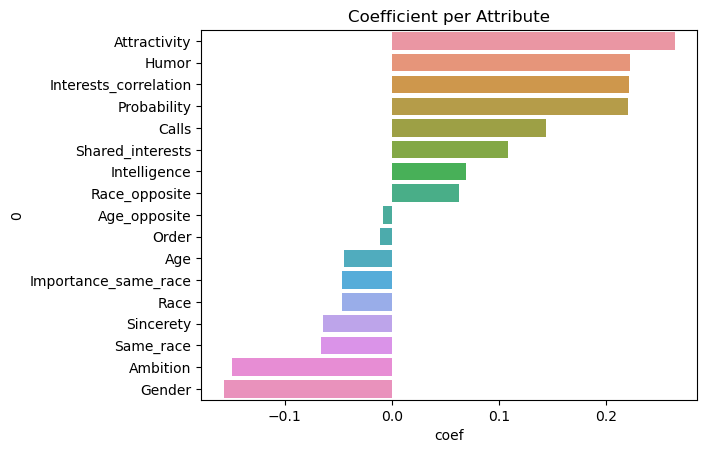

In [65]:
log_reg_1 = LogisticRegressionCV(max_iter=1000)
log_reg_1.fit(X_train_c, y_train_c)

res = pd.DataFrame(np.row_stack(list(X_test_c.columns)))
res = res.assign(coef=log_reg_1.coef_.tolist()[0])
res.sort_values('coef',  ascending=False,inplace=True)
sns.barplot(res,y=0,x='coef').set(title="Coefficient per Attribute")

Based on the metrics our model performs poor, predicting a lot of no matches. The R1 score for a match is very low (0.24). There are only 33 cases where we do a correct prediction of the match outcome.

This may be based on the origin data where we have a lot more no-match entries than matches.

In [66]:
def metrics_confusionmatrix(log_reg, X_test_c, y_test_c):
    '''
    This function predicts y and prints confusion matrix and classifiaction report. Returns y_pred_c and y_proba_c.
    '''
    y_pred_c = log_reg.predict(X_test_c)
    y_proba_c = log_reg.predict_proba(X_test_c)[:, 1]

    fig, ax = plt.subplots(figsize=(3, 3))
    ConfusionMatrixDisplay.from_estimator(log_reg, X_test_c, y_test_c, ax=ax, colorbar=False)
    
    print(classification_report(y_test_c, y_pred_c, target_names=['No match', 'Match']))

    return y_pred_c, y_proba_c

In [67]:
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [89]:
def metrics_precisionrecall(log_reg, X_test_c, y_test_c, model_name):
    '''
    This function displays the PrecisionRecallDisplay
    '''    
    fig, ax = plt.subplots(figsize=(5, 3))
    PrecisionRecallDisplay.from_estimator(log_reg, X_test_c, y_test_c, name=model_name, ax=ax)

In [90]:
def metrics_roc(log_reg, X_test_c, y_test_c, y_proba_c, model_name):
    '''
    This function displays the RocCurveDisplay and roc_auc_score
    '''
    fig, ax = plt.subplots(figsize=(5, 3))
    RocCurveDisplay.from_estimator(log_reg, X_test_c, y_test_c, name=model_name, ax=ax)
    fpr, tpr, thresholds = roc_curve(y_test_c, y_proba_c)
    print(f"The AUC score is: {roc_auc_score(y_test_c, y_proba_c)}")

    return fpr, tpr

The **F1-Score** is calculated by: 2 * Precision * Recall / Precision + Recall.<br>
It takes the harmonic mean of precision and recall into account when optimizing the model. Values closer to 1 indicate a better performance.

The **Accuracy** is calculated by: Number of correct predictions / Total number of predictions.<br>
It's the portion of correct predictions.

Because our model does a lot of correct (true negative) predictions, the Accuracy score is high.

              precision    recall  f1-score   support

    No match       0.84      0.97      0.90      1118
       Match       0.51      0.14      0.22       239

    accuracy                           0.82      1357
   macro avg       0.67      0.55      0.56      1357
weighted avg       0.78      0.82      0.78      1357



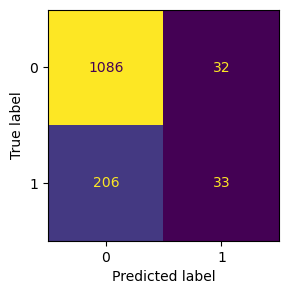

In [70]:
y_pred_c, y_proba_c = metrics_confusionmatrix(log_reg_1, X_test_c, y_test_c)

In [71]:
result_1 = metrics_calculator(y_test_c, y_pred_c, 'Full_LogRegCV')
result_1

Full_LogRegCV
Accuracy        0.824613
Precision       0.674125
Recall          0.554726
F1-score        0.559175

The **Precision-Recall** curve summarizes the trade-off between the **true positive rate (Recall)** and the **positive predictive value (Precision)**.

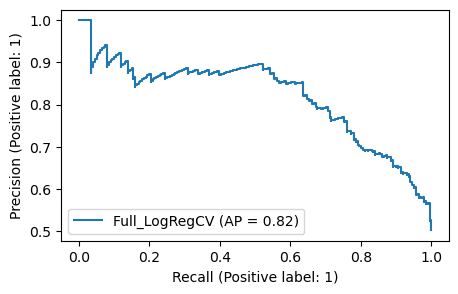

In [91]:
metrics_precisionrecall(log_reg_1, X_test_c, y_test_c, 'Full_LogRegCV')

The **Receiver Operating Characteristic (ROC) Curve** summarizes the trade-off between the **true positive rate** and **false positive rate**.

ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.

Therefore the ROC curve looks good, although our model is in fact bad.
This is caused by the high **true negative** rate in our model that is taken into account in the ROC but not in the Precision-Recall metric.

The AUC score is: 0.8440961024025601


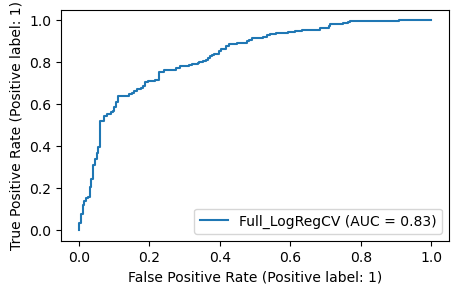

In [92]:
fpr1, tpr1 = metrics_roc(log_reg_1, X_test_c, y_test_c, y_proba_c, 'Full_LogRegCV')

We can try to even the numbers and train the model again.

In [74]:
df_new = pd.concat([df_c[df_c[y_label_c] == 0][:1000], df_c[df_c[y_label_c] == 1][:1000]])

alt.Chart(df_new).mark_bar().encode(
    alt.X(y_label_c),
    alt.Y('count()'),
    alt.Color(y_label_c),
    tooltip = ['count()']
).properties(
    width=250,
    height=150
).interactive().properties(title="1000 match and no-match data")

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Result

Our model looks a lot better now with a **F1 score** of 0.75.<br>
We do a correct estimation of a match in 152 of the cases and a correct estimation of no-match in 148 so in 3/4 of all cases we are correct and the **Accuracy** is at 75%.

Based on the dating behaviour it may be better to maximise the precision of match (have a lot of dates but less matches) or recall (have less dates but more matches). Because a match is still very personal, it is probably better to tune for precision. 

In [75]:
X_c = df_new[features_classification]
y_c = df_new[y_label_c] 

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    random_state=42)

In [76]:
log_reg_2 = LogisticRegressionCV(max_iter=200)
log_reg_2.fit(X_train_c, y_train_c)

LogisticRegressionCV(max_iter=200)

              precision    recall  f1-score   support

    No match       0.75      0.74      0.75       199
       Match       0.75      0.76      0.75       201

    accuracy                           0.75       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.75      0.75       400



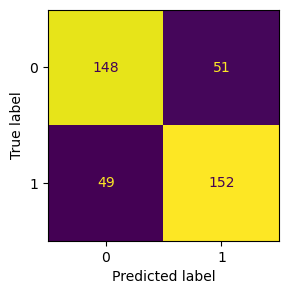

In [77]:
y_pred_c, y_proba_c = metrics_confusionmatrix(log_reg_2, X_test_c, y_test_c)

In [78]:
result_2 = metrics_calculator(y_test_c, y_pred_c, '1000_LogRegCV')
result_2

1000_LogRegCV
Accuracy        0.750000
Precision       0.750019
Recall          0.749969
F1-score        0.749975

While the **AUC Score** stays roughly the same, the **Precision-Recall** curve looks a lot better now.

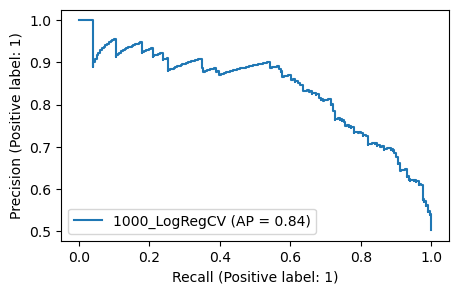

In [93]:
metrics_precisionrecall(log_reg_2, X_test_c, y_test_c, '1000_LogRegCV')

The AUC score is: 0.8440961024025601


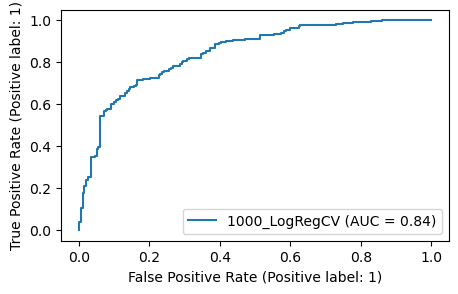

In [94]:
fpr2, tpr2 = metrics_roc(log_reg_2, X_test_c, y_test_c, y_proba_c, '1000_LogRegCV')

### Tuning

We could tune the model very hard, so we *could* predict 22 partners and 21 of them would be a real match (in theory). See appendix.

In this case we tune for optimal f1 score with a GridSearch.

In [81]:
log_reg_3 = LogisticRegression(max_iter=200) 

In [82]:
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 'penalty':['none'], 'max_iter':[10000]},
              {'solver':['lbfgs', 'newton-cg', 'sag'], 'penalty':['l2'], 'C':np.logspace(-4, 4, 20), 'max_iter':[10000]},
              {'solver':['liblinear', 'saga'], 'penalty': ['l1', 'l2'], 'C':np.logspace(-4, 4, 20), 'max_iter':[10000]},
              {'solver':['saga'], 'penalty':['elasticnet'], 'C': np.logspace(-4, 4, 20), 'l1_ratio': np.arange(0,1.1,0.1), 'max_iter':[10000]}]    

In [83]:
logistic_grid = GridSearchCV(estimator =  log_reg_3,
                             param_grid = param_grid,
                             cv = StratifiedKFold(5, shuffle=True, random_state=0),
                             scoring = 'accuracy',
                             n_jobs = -1,
                             verbose = 1)

In [84]:
logistic_grid.fit(X_train_c, y_train_c)

Fitting 5 folds for each of 364 candidates, totalling 1820 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=LogisticRegression(max_iter=200), n_jobs=-1,
             param_grid=[{'max_iter': [10000], 'penalty': ['none'],
                          'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']},
                         {'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'max_iter': [10000], 'penalty': ['elasticnet'],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=1)

              precision    recall  f1-score   support

    No match       0.75      0.77      0.76       199
       Match       0.77      0.75      0.76       201

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400



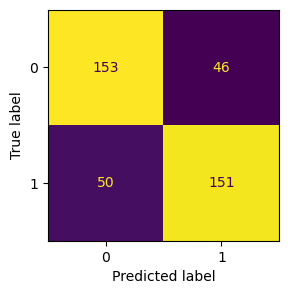

In [85]:
y_pred_c, y_proba_c = metrics_confusionmatrix(logistic_grid, X_test_c, y_test_c)

Comparing the models, there is no big difference between the first model with a dataset of 2000 observations and the tuned one but balancing the dataset had a great effect on the model.

In [86]:
final_result = metrics_calculator(y_test_c, y_pred_c, '1000_LogReg_GridSearchCV')
final_scores = pd.concat([result_1, result_2, final_result], axis=1)

In [87]:
final_scores_t = final_scores.T
final_scores_t['Name'] = final_scores.columns
final_scores_t

accuracy = alt.Chart(final_scores_t).mark_bar().encode(
    y='Name',
    x='Accuracy:Q',
    color='Name',
    tooltip='Accuracy:Q'
)

a_text = accuracy.mark_text(
    align='center',
    baseline='middle',
    dx=45  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Accuracy:Q'
)

precision = alt.Chart(final_scores_t).mark_bar().encode(
    y=('Name'),
    x=('Precision:Q'),
    color='Name',
    tooltip='Precision:Q'
)

p_text = precision.mark_text(
    align='center',
    baseline='middle',
    dx=45  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Precision:Q'
)

recall = alt.Chart(final_scores_t).mark_bar().encode(
    y=('Name'),
    x=('Recall:Q'),
    color='Name',
    tooltip='Recall:Q'
)

r_text = recall.mark_text(
    align='center',
    baseline='middle',
    dx=45  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Recall:Q'
)


f1 = alt.Chart(final_scores_t).mark_bar().encode(
    y=('Name'),
    x=('F1-score:Q'),
    color='Name',
    tooltip='F1-score:Q'
)

f1_text = f1.mark_text(
    align='center',
    baseline='middle',
    dx=45  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='F1-score:Q'
)

(precision + p_text) & (recall + r_text) & (accuracy + a_text) & (f1 + f1_text)

c:\Users\lukas\anaconda3\envs\stats\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

The AUC score is: 0.8440961024025601


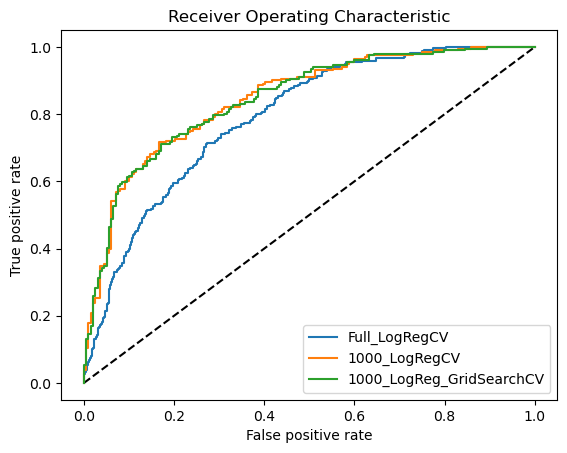

In [88]:
#roc_final = RocCurveDisplay.from_estimator(logistic_grid, X_test_c, y_test_c, name='LogisticRegression_Grid')
fpr3, tpr3, thresholds3 = roc_curve(y_test_c, y_proba_c)
print(f"The AUC score is: {roc_auc_score(y_test_c, y_proba_c)}")

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Full_LogRegCV")
plt.plot(fpr2, tpr2, label= "1000_LogRegCV")
plt.plot(fpr3, tpr3, label= "1000_LogReg_GridSearchCV")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('Receiver Operating Characteristic')
plt.show() 

## Discussion + Conclusion


With the data from this survey and our used statistical methods and classification, we could answer the following research questions:


-   **What are the most effective personal characteristics to achieve a match in opposite sex speed dating?**
    - According to our model parameters the most important features for a positive correlation are: **attractivity**, **same interests**, **humor** and that the other person also shows some **interest**.<br>On the other hand there is a negative correlation for beeing the same gender and race and being (maybe too) ambitious and sincere.

Null hypothesis:

-   **There is no affection of having specific characteristics regarding match selection of the survey participants**
    - This does not hold true, the characteristics are described above.
-   **There is no correlation between shared interests, attributes and getting a match**
    - This does not hold true, the characteristics are described above.

Hypotheses:

-   **Survey participants who both have the specific characteristics same race and opposite gender tend to achieve more matches**
    - We didn't investigate that in detail, but we saw a rather negative correlation between same race and match.
-   **Survey participants with a higher income tend to achieve more matches than survey participants with a lower income**
    - We didn't investigate that in detail, as the income wasn't an important feature for our model.
-   **Achieving matches because of having the same specific characteristics occur in both sexes**
    - Yes, this hypotheses is true.
-   **Three weeks after the event, males called women more often**
    - Yes, by the factor of four. See appendix.
  
With our report, we contribute to a better understanding of the topic of speed dating and the preferences of the participants.<br>
Our paper serves as an important starting point in understanding the preferences underlying the search for a partner. <br>
Prior work has shown how to achieve matches, but in this report we compare these needed features and give an example which attributes a speed dating participant need to have in order to achieve matches and likes.<br>
In this report, we use an explorative data analysis approach that allows us to directly observe individual decisions.

There are a number of ways that our work may be improved. Due to the limitation of the data collection method - a local survey in only one country, we have a very specific distribution of races throughout the speed dating participants.<br>
Also, in terms of the validity of our dataset, gender politics have changed since 2008, and we have largely ignored gender diversity and focused only on men and women, altough those two genders don't really show a significant difference in the data. <br>
Most notably, a similar methodology could be employed on a newer set of data, because our data set is more than 10 years old.

## Appendix

### Data Dictionary

#### Descriptive terms for our used variables 

| Name  |Description                                                                                                         | Descriptive term      | 
|-------|---------------------------------------------------------------------------------------------------------------------|-----------|
| calls   | Event of a participant conducting a "you_call" or "them_cal" with the other party                                 | Calls of participants |
| attr  | Rating of the attribute for this person from 1 - 10.                                                                | Attractivity of speed dating participant | 
| sinc  | Rating of the attribute for this person from 1 - 10.                                                                | Sincerety of speed dating participant | 
| intel | Rating of the attribute for this person from 1 - 10.                                                                | Intelligence of speed dating participant  | 
| fun   | Rating of the attribute for this person from 1 - 10.                                                                | Humor of speed dating participant | 
| amb   | Rating of the attribute for this person from 1 - 10.                                                                | Ambition of speed dating participant | 
| shar  | Rating of the attribute for this person from 1 - 10.                                                                | Shared Interests/Hobbies of the speed dating participant to the other party | 
| like  | Overall, how much do oyu like this person. 1 (don't like at all) to 10 (like a lot)                                 | Strength of like of speed dating participant to the other party | 
| prob  | How probable do you think it is that this person will say 'yes' for you? 1 (not probable) to 10 (extemely probable) | Probability of speed dating participant to like the other party | 
| met   | Have you met this person before? (1 = yes, 2 = no)                                                                  | Meeting indicator of participants | 
| gender   | Gender of the person. Female = 0, Male = 1                                                                       | Gender of speed dating participant |
| order    | The number of date that night when met partner                                                                   | Order of date of speed dating participant and the other party during event  |
| match    | 1 = yes, 0 = no                                                                                                  | Match of the speed dating participant and the other party  |
| int_corr | Correlation between participant's and partner's ratings of interests in Time 1                                   | Correlation of the speed dating participant and the other party |
| samerace | Participant and the partner were the same race. 1 =  yes, 0 = no                                                 | Indicates, if the speed dating participant and the other party have the same race  |
| age       | Age of the person                                                                                               | Age of speed dating participant |
| age_o    | Age of partner                                                                                                   | Age of other party |
| race      | Race of the attendee<br/>1 = Black/African American<br/>2 = European/Caucasian-American<br/>3 = Latino/Hispanic American<br/>4 = Asian/Pacific Islander/Asian-American<br/>5 = Native American<br/>6 = Other                                                                                                           | Race of speed dating participant |
| race_o   | Race of partner                                                                                                     | Race of other party |
| imprace   | How important is it that a person you date be of the same racial/ethic background? (1 - 10)                        | Importance of the other party having the same race as the speed dating participant |
| intel_o   | Intelligent. Rating by partner the night of the event from 1 (awful) to 10 (great)                                 | Intelligence of the other party |
| sinc_o    | Sincere. Rating by partner the night of the event from 1 (awful) to 10 (great)                                     | Sincerety of the other party |
| like_o   | Overall, how much do oyu like this person. 1 (don't like at all) to 10 (like a lot)                        | Strength of like of to the other party |
| prob_o   | How probable do you think it is that this person will say 'yes' for you? 1 (not probable) to 10 (extemely probable)                        | Probability of the other party to like speed dating participant |
| fun_o   | Fun. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Humor of the other party |
| satis_2   | Generic Id                        | Generic Id  |
| amb_o   | Ambitious. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Ambition of the other party |
| shar_o   | Shared Interests/Hobbies. Rating by partner the night of the event from 1 (awful) to 10 (great)                          | Shared Interests/Hobbies of the other party to speed dating participant |
| attr_o   | Attractive. Rating by partner the night of the event from 1 (awful) to 10 (great)                        | Attractivity of the other party |
| met_o   | Have you met this person before? (1 = yes, 2 = no)                         | Meeting indicator of the other party  |
| exphappy   | Overall, on a scale of 1-10, how happy do you expect to be with the people you meet during the speed-dating event?                        | Expected Happiness of meeting people |
| pid   | partner's iid number                       | partner's iid number |


### Tuning

The lower the thresholds, the more false positives we have.

In [ ]:
pred_proba = log_reg_2.predict_proba(X_test_c)
df_02 = pd.DataFrame({'y_pred': pred_proba[:,1] > .41})

ConfusionMatrixDisplay.from_predictions(y_test_c, df_02['y_pred']);

print(classification_report(y_test_c, df_02['y_pred']))


The higher the thresholds, the more false negatives we have.
If we want to tune it very hard, we can predict 22 partners and 21 of them would be a real match.

This would make sense if we want to make predictions for a person with whom the person should go on a date.

In [ ]:
pred_proba = log_reg_2.predict_proba(X_test_c)
df_02 = pd.DataFrame({'y_pred': pred_proba[:,1] > .9})

ConfusionMatrixDisplay.from_predictions(y_test_c, df_02['y_pred']);

print(classification_report(y_test_c, df_02['y_pred']))

### You call them call comparison of male and female

We can see that a lot more male (2.422) are calling female than the other way round (681).<br>
On the other hand, both sexes said that they have been called more often than there were actual calls (male 1.035/681 and female 2.866/2.422), maybe there is some bias about these numbers or the data is incomplete.

In [ ]:
df_origin = pd.read_csv("../data/interim/TransformedData", delimiter=",", index_col=0)

alt.Chart(df_origin).mark_bar().encode(
    alt.X('gender:O', title='female,male'),
    y='sum(you_call)',
    color='gender:O',
    tooltip='sum(you_call)'
) | alt.Chart(df_origin).mark_bar().encode(
    alt.X('gender:O', title='female,male'),
    y='sum(them_cal)',
    color='gender:O',
    tooltip='sum(them_cal)'
).properties(
    title='Distribution of calls per gender'
) 